In [1]:
import pandas as pd

DATA = '/kaggle/input/college-football-team-stats-2002-to-january-2024/cfb_box-scores_2002-2023.csv'
df = pd.read_csv(filepath_or_buffer=DATA)
df.head()

,season,week,date,time_et,game_type,away,home,rank_away,rank_home,conf_away,...,int_away,int_home,pen_num_away,pen_yards_away,pen_num_home,pen_yards_home,possession_away,possession_home,attendance,tv
0,2002,1.0,2002-08-22,7:30 PM,regular,Colorado State,Virginia,NaN,NaN,mwc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57120.0,NaN
1,2002,1.0,2002-08-23,8:00 PM,regular,Fresno State,Wisconsin,NaN,25.0,wac,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75136.0,NaN
2,2002,1.0,2002-08-24,2:30 PM,regular,Texas Tech,Ohio State,NaN,13.0,big12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100037.0,NaN
3,2002,1.0,2002-08-24,4:30 PM,regular,New Mexico,NC State,NaN,NaN,mwc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47018.0,NaN
4,2002,1.0,2002-08-24,7:45 PM,regular,Arizona State,Nebraska,NaN,10.0,pac12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77779.0,NaN


How big is our dataset?

<Axes: xlabel='season'>

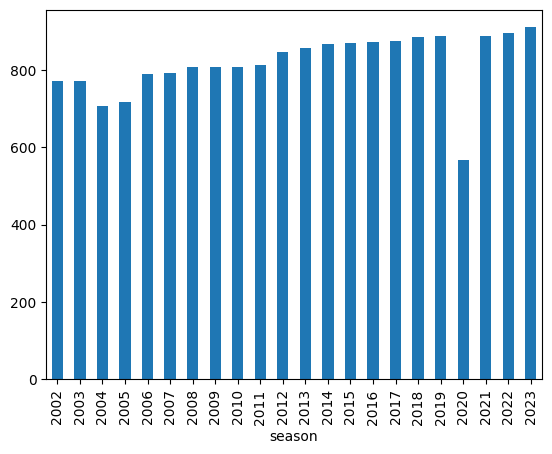

In [2]:
df['season'].value_counts().sort_index().plot(kind='bar')

We have roughly 800 games a year for 21 years; that's a lot of games.

Let's get just the win/loss figures first, and put them in a separate DataFrame.

In [3]:
win_loss_df = df[['season', 'home', 'away', 'score_away', 'score_home']].copy()
win_loss_df['W'] = win_loss_df.apply(axis='columns', func=lambda x: x['home'] if x['score_home'] > x['score_away'] else x['away'])
win_loss_df['L'] = win_loss_df.apply(axis='columns', func=lambda x: x['home'] if x['score_home'] < x['score_away'] else x['away'])

Which teams have the most losses over the period of interest?

In [4]:
win_loss_df['L'].value_counts().head(n=10).to_frame().T

L,UNLV,New Mexico State,Kansas,Akron,Eastern Michigan,UTEP,Vanderbilt,UL-Monroe,New Mexico,Illinois
count,182,182,177,176,176,174,174,170,170,168


Which teams have the most wins over the period of interest?

In [5]:
win_loss_df['W'].value_counts().head(n=10).to_frame().T

W,Ohio State,Alabama,Georgia,Oklahoma,Boise State,Clemson,LSU,USC,Oregon,Wisconsin
count,244,243,232,231,231,220,216,205,203,202


In [6]:
win_loss_df['L score'] = win_loss_df[['score_away', 'score_home']].min(axis='columns')
win_loss_df['W score'] = win_loss_df[['score_away', 'score_home']].max(axis='columns')

In [7]:
win_loss_df.head(n=5)

,season,home,away,score_away,score_home,W,L,L score,W score
0,2002,Virginia,Colorado State,35,29,Colorado State,Virginia,29,35
1,2002,Wisconsin,Fresno State,21,23,Wisconsin,Fresno State,21,23
2,2002,Ohio State,Texas Tech,21,45,Ohio State,Texas Tech,21,45
3,2002,NC State,New Mexico,14,34,NC State,New Mexico,14,34
4,2002,Nebraska,Arizona State,10,48,Nebraska,Arizona State,10,48


Let's collect each year into its own DataFrame.

In [8]:
wl = {season: win_loss_df[win_loss_df['season'] == season] for season in win_loss_df['season'].unique().tolist()}

In [9]:
print(list(wl.keys()))

[2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


How many distinct home teams do we have?

In [10]:
df['home'].nunique()

139

In [11]:
wl[2002][wl[2002]['home'] == 'Colorado State']

,season,home,away,score_away,score_home,W,L,L score,W score
185,2002,Colorado State,Louisville,33,36,Colorado State,Louisville,33,36
369,2002,Colorado State,Wyoming,36,44,Colorado State,Wyoming,36,44
452,2002,Colorado State,BYU,10,37,Colorado State,BYU,10,37
702,2002,Colorado State,New Mexico,14,22,Colorado State,New Mexico,14,22
723,2002,Colorado State,UNLV,36,33,UNLV,Colorado State,33,36
760,2002,Colorado State,TCU,17,3,TCU,Colorado State,3,17


In [12]:
win_loss_df[win_loss_df['W'] == 'TCU'].groupby(by='season').size().to_frame().T

season,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,10,11,5,11,11,8,11,12,13,11,...,12,11,6,11,7,5,6,5,13,5
